### Подключение библиотек

In [1]:
import math
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к файлам

In [134]:
TRAIN_DATASET_PATH = "./train.csv"
TEST_DATASET_PATH = "./test.csv"
SUBMIT_DATASET_PATH = "./sample_submission.csv";

### Загрузка файлов

#### Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, ",")
df_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630


In [7]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
df_test = pd.read_csv(TEST_DATASET_PATH, ",")
df_test.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B


In [9]:
print('Строк в трейне:', df_train.shape[0])
print('Строк в тесте', df_test.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


#### Приведение типов

In [10]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_train.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### EDA

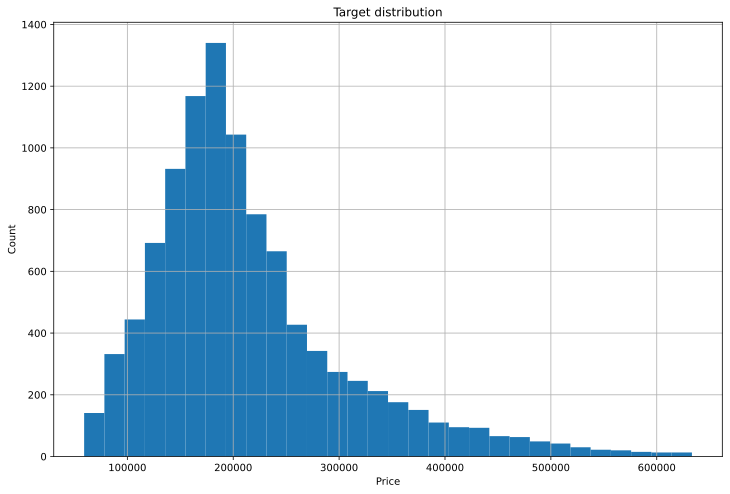

In [11]:
plt.figure(figsize = (12, 8))

df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### Количественные переменные

In [12]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Номинативные переменные

In [13]:
df_train.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [14]:
df_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
196      1
207      1
117      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [15]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [16]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [17]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

#### Rooms

In [18]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Будем считать что квартиры с количеством комнат равным нулю имеют одну комнату, а все квартиры где указано, 
что комнат больше 5 заменин на медиану. И заведем новое поле где удем отмечать где были модифицированы данные у комнат

In [19]:
df_train['Rooms_outlier'] = 0
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] >= 6), 'Rooms_outlier'] = 1
df_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0


In [20]:
df_train.loc[df_train['Rooms'] == 0, 'Rooms'] = 1
df_train.loc[df_train['Rooms'] >= 6, 'Rooms'] = df_train['Rooms'].median()

In [21]:
df_train['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Square

In [22]:
df_train['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [23]:
df_train['Square'].value_counts()

52.327165    1
34.785487    1
45.823093    1
57.607965    1
57.925603    1
            ..
60.776683    1
72.956943    1
51.770111    1
41.843220    1
64.226361    1
Name: Square, Length: 10000, dtype: int64

In [24]:
df_train['Square'].quantile(.995), df_train['Square'].quantile(.005)

(132.82090134811978, 27.245409330530855)

Заведем отдельное поле для пометки выбросов и всем квартирам где общая площадь превышает 132 кв м присвоим медиану. а тем где меньше 27 кв м, присвоим 27

In [25]:
df_train['Square_outlier'] = 0
df_train.loc[(df_train['Square'] < 27) | (df_train['Square'] > 132), 'Square_outlier'] = 1
df_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.871089,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.720850,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.007630,0,0


In [26]:
df_train.loc[df_train['Square'] < 27, 'Square'] = 27
df_train.loc[df_train['Square'] > 132, 'Square'] = df_train['Square'].median()
df_train['Square'].describe()

count    10000.000000
mean        55.698403
std         17.606006
min         27.000000
25%         41.774881
50%         52.513040
75%         65.684193
max        129.998756
Name: Square, dtype: float64

#### LifeSquare

In [27]:
df_train['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [28]:
df_train['LifeSquare'].quantile(.975), df_train['LifeSquare'].quantile(.025)

(80.74810407514713, 5.914129735023812)

Заведем отдельное поле для пометки выбросов и всем квартирам где жилая площадь превышает 80 кв м присвоим медиану, а тем где меньше 5 кв м, присвоим 5

In [29]:
df_train['LifeSquare_outlier'] = 0
df_train.loc[(df_train['LifeSquare'] < 5) | (df_train['LifeSquare'] > 80), 'LifeSquare_outlier'] = 1
df_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.871089,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.553407,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.720850,0,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.007630,0,0,0


In [30]:
df_train.loc[df_train['LifeSquare'] < 5, 'LifeSquare'] = 5
df_train.loc[df_train['LifeSquare'] > 80, 'LifeSquare'] = df_train['LifeSquare'].median()
df_train['LifeSquare'].describe()

count    7887.000000
mean       34.409294
std        14.159412
min         5.000000
25%        22.769832
50%        32.781260
75%        43.823731
max        79.847797
Name: LifeSquare, dtype: float64

#### KitchenSquare

In [31]:
df_train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [32]:
df_train['KitchenSquare'].quantile(.975), df_train['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [33]:
df_train['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

Заведем отдельное поле для пометки выбросов по всем квартирам где площадь кухни превышает 13 кв м присвоим медиану, а тем где меньше 3 кв м, присвоим 3

In [34]:
df_train['KitchenSquare_outlier'] = 0
df_train.loc[(df_train['KitchenSquare'] < 3) | (df_train['KitchenSquare'] > 13), 'KitchenSquare_outlier'] = 1
df_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,NaN,0,0,B,305018.871089,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,B,177734.553407,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,B,282078.720850,0,0,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,0,NaN,0,1,B,168106.007630,0,0,0,1


In [35]:
df_train.loc[df_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3
df_train.loc[df_train['KitchenSquare'] > 13, 'KitchenSquare'] = df_train['KitchenSquare'].median()
df_train['KitchenSquare'].describe()

count    10000.000000
mean         6.238200
std          2.794717
min          3.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         13.000000
Name: KitchenSquare, dtype: float64

In [36]:
df_train['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

#### HouseFloor	, Floor

In [37]:
df_train['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
39.0        2
48.0        2
99.0        2
29.0        1
44.0        1
47.0        1
36.0        1
31.0        1
38.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

In [38]:
df_train['HouseFloor'].describe()

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

Здесь всем домам у которых 0 этажей присвоим медиану, возможно этажности которых только 7 или меньше являются выбросами, 
но пока не знаю как их правильно обработать

In [39]:
df_train['HouseFloor_outlier'] = 0
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
df_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,NaN,0,0,B,305018.871089,0,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,B,177734.553407,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,B,282078.720850,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,...,NaN,0,1,B,168106.007630,0,0,0,1,0


In [40]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()
df_train['HouseFloor'].describe()

count    10000.00000
mean        12.95910
std          6.44346
min          1.00000
25%          9.00000
50%         13.00000
75%         17.00000
max        117.00000
Name: HouseFloor, dtype: float64

In [41]:
(df_train['Floor'] > df_train['HouseFloor']).sum()

1610

In [42]:
df_train['Floor'].describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

Есть очень много этажей которые выше этажности дома, присвоим этим квартирам  случайное число этажа 
не превышающее этажности квартиры

In [43]:
df_train['Floor_outlier'] = 0
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'Floor_outlier'] = 1
df_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,0,B,305018.871089,0,0,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,B,177734.553407,0,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,B,282078.720850,0,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,...,0,1,B,168106.007630,0,0,0,1,0,0


In [44]:
floor_outliers = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [45]:
df_train.loc[floor_outliers, 'Floor'] = df_train.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
(df_train['Floor'] > df_train['HouseFloor']).sum()

0

In [46]:
df_train['Floor'].describe()

count    10000.000000
mean         7.397100
std          5.032449
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         42.000000
Name: Floor, dtype: float64

#### HouseYear

In [47]:
df_train['HouseYear'].describe()

count    1.000000e+04
mean     3.990166e+03
std      2.005003e+05
min      1.910000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [48]:
df_train['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

Есть слишком большие года, присвоим им текущий год

In [49]:
current_year = datetime.now().year
df_train['HouseYear_outlier'] = 0
df_train.loc[df_train['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
df_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,B,305018.871089,0,0,0,0,0,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,B,177734.553407,0,0,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,B,282078.720850,0,0,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,...,1,B,168106.007630,0,0,0,1,0,0,0


In [50]:
df_train.loc[df_train['HouseYear'] > current_year, 'HouseYear'] = current_year
df_train['HouseYear'].describe()

count    10000.000000
mean      1984.872600
std         18.416734
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2021.000000
Name: HouseYear, dtype: float64

In [51]:
df_train['HouseYear'].sort_values(ascending=False)

8828    2021
9163    2021
7721    2020
9122    2020
7955    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int64

Показатели экологии, медицины, магазинов и социальные показатели пока не совсем понятно как обрабатывать, оставим как есть

### Обработка пропусков

In [52]:
df_train.isna().sum()

Id                          0
DistrictId                  0
Rooms                       0
Square                      0
LifeSquare               2113
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1             4798
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
Price                       0
Rooms_outlier               0
Square_outlier              0
LifeSquare_outlier          0
KitchenSquare_outlier       0
HouseFloor_outlier          0
Floor_outlier               0
HouseYear_outlier           0
dtype: int64

#### LifeSquare

In [53]:
df_train['LifeSquare_nan'] = df_train['LifeSquare'].isna() * 1
df_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,305018.871089,0,0,0,0,0,0,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,177734.553407,0,0,0,0,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,282078.720850,0,0,0,0,0,0,0,0
3,2352,1,1.0,40.409907,NaN,3.0,10,22.0,1977,0.007122,...,B,168106.007630,0,0,0,1,0,0,0,1


In [54]:
condition = (df_train['LifeSquare'].isna()) \
             & (~df_train['Square'].isna()) \
             & (~df_train['KitchenSquare'].isna())
        
df_train.loc[condition, 'LifeSquare'] = df_train.loc[condition, 'Square'] \
                                            - df_train.loc[condition, 'KitchenSquare'] - 3

#### Healthcare_1

In [55]:
df_train.drop('Healthcare_1', axis=1, inplace=True)

In [56]:
df_train.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
Square_outlier           0
LifeSquare_outlier       0
KitchenSquare_outlier    0
HouseFloor_outlier       0
Floor_outlier            0
HouseYear_outlier        0
LifeSquare_nan           0
dtype: int64

In [57]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
        self.square_up_quantile = math.floor(X['Square'].quantile(.995))
        self.square_down_quantile = math.floor(X['Square'].quantile(.005))
        
        self.life_square_up_quantile = math.floor(X['LifeSquare'].quantile(.975))
        self.life_square_down_quantile = math.floor(X['LifeSquare'].quantile(.025))
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        X['Square_outlier'] = 0
        X.loc[(X['Square'] < self.square_down_quantile) | (X['Square'] > self.square_up_quantile), 'Square_outlier'] = 1
        X.loc[X['Square'] < self.square_down_quantile, 'Square'] = self.square_down_quantile
        X.loc[X['Square'] > self.square_up_quantile, 'Square'] = X['Square'].median()
        
        # LifeSquare
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'] < self.life_square_down_quantile) | (X['LifeSquare'] > self.life_square_up_quantile), 'LifeSquare_outlier'] = 1
        X.loc[X['LifeSquare'] < self.life_square_down_quantile, 'LifeSquare'] = self.life_square_down_quantile
        X.loc[X['LifeSquare'] > self.life_square_up_quantile, 'LifeSquare'] = X['LifeSquare'].median()
        
        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] > self.kitchen_square_quantile), 'KitchenSquare_outlier'] = 1
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > self.kitchen_square_quantile, 'KitchenSquare'] = X['KitchenSquare'].median()
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X['HouseFloor'].median()
        X['Floor_outlier'] = 0
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor_outlier'] = 1
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

#### Dummies

In [58]:
binary_to_numbers = {'A': 0, 'B': 1}

df_train['Ecology_2'] = df_train['Ecology_2'].replace(binary_to_numbers)
df_train['Ecology_3'] = df_train['Ecology_3'].replace(binary_to_numbers)
df_train['Shops_2'] = df_train['Shops_2'].replace(binary_to_numbers)

df_train[['Ecology_2', 'Ecology_3', 'Shops_2']].head(4)

,Ecology_2,Ecology_3,Shops_2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1


#### DistrictSize, IsDistrictLarge

Для каждого района определим количество квартир которые в нём находятся и вынесем это число в новый признак

In [59]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [60]:
df_train = df_train.merge(district_size, on='DistrictId', how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,0,0,0,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,0,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,0,0,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,0,1,0,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,0,0,0,0,0,89


Будем считать что если в районе больше 100 квартир, то это большой район, добавим новый признак для определения этого

In [61]:
(df_train['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [62]:
df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,0,0,0,0,0,1,851,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,0,0,0,78,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,0,0,0,652,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,0,0,1,0,0,0,1,652,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0,0,0,0,89,0


#### MedPriceByDistrict

Добавим новый признак который будет содержать медиану стоимости квартир по каждому району для квартир с разным количеством комнат, позже это можно будет применить к тестовым данным

In [63]:
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [64]:
med_price_by_district.shape

(667, 3)

In [65]:
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Square_outlier,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,0,0,0,0,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,0,1,0,0,0,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0,0,0,89,0,201584.441255


#### MedPriceByFloorYear

Так же вычислим медиану стоимости квартиры в зависимости от года постройки дома и номера этажа. Для уменьшения количества медиан разобъем года и этажность на отдельные категории и будем вычислять медиану от них

In [66]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [67]:
bins = [0, 3, 5, 9, 15, df_train['Floor'].max()]
pd.cut(df_train['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [68]:
bins = [0, 3, 5, 9, 15, df_train['Floor'].max()]
pd.cut(df_train['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [69]:
df_train = year_to_cat(df_train)
df_train = floor_to_cat(df_train)
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,KitchenSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,0,0,1,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,0,0,0,1,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,0,89,0,201584.441255,3,5


In [70]:
med_price_by_floor_year = df_train.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,343812.494282
1,1,2,324303.812481
2,1,3,425423.585714
3,1,4,274992.472366
4,2,1,467230.539057


In [71]:
df_train = df_train.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,0,1,851,1,213530.788443,6,2,167082.631131
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,0,78,0,146032.829834,3,3,191371.457255
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,0,652,1,244005.272380,4,1,204940.082609
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,0,0,1,652,1,146735.671740,3,4,183505.979560
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,0,89,0,201584.441255,3,5,173028.982008


In [72]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### Отбор признаков

In [73]:
df_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'Square_outlier',
 'LifeSquare_outlier',
 'KitchenSquare_outlier',
 'HouseFloor_outlier',
 'Floor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [74]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'Square_outlier', 'LifeSquare_outlier', 'KitchenSquare_outlier', 'HouseFloor_outlier', 
                     'HouseYear_outlier', 'Floor_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge', 'MedPriceByFloorYear']

target_name = 'Price'

### Разбиение на train и test

In [75]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [76]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [77]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [78]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 33), (3300, 33), (5000, 33))

In [79]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [80]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели

#### Поиск подходящих параметров для модели обучения

In [109]:
fr_model = RandomForestRegressor(criterion='mse',
                                     random_state=42)

In [110]:
%%time
params = {
    'n_estimators': [50, 100, 200, 400], 
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [10, 20, 30]
}

gs = GridSearchCV(fr_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 2min 23s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [10, 20, 30],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [111]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.564585,0.008162,0.015082,0.003086,3,10,50,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",0.543934,0.560201,0.613032,0.589361,0.601749,0.581655,0.025810,40
1,1.140102,0.017743,0.022252,0.004447,3,10,100,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",0.545428,0.560396,0.612774,0.588079,0.603145,0.581964,0.025437,37


In [112]:
gs.best_params_

{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 400}

In [113]:
gs.best_score_

0.7110059423865673

#### Обучение

In [127]:
final_model = RandomForestRegressor(criterion='mse', random_state=42, **gs.best_params_)

final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=10, n_estimators=400,
                      random_state=42)

#### Оценка модели

Train R2:	0.797
Test R2:	0.716


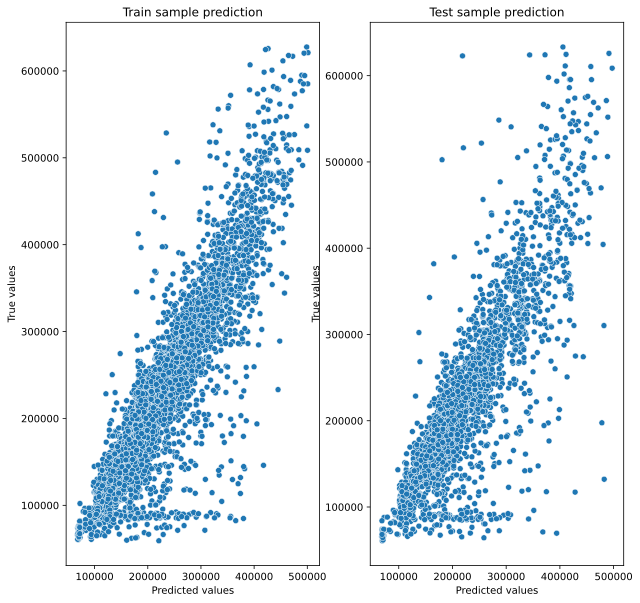

In [128]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Кросс-валидация

In [121]:
cv_score = cross_val_score(final_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.7278817 , 0.65592944, 0.71249874])

In [122]:
cv_score.mean()

0.6987699618125113

#### Важность признаков

In [123]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,4.881041e-01
24,DistrictSize,2.837092e-01
12,Social_3,5.555612e-02
7,Ecology_1,2.979440e-02
0,Rooms,2.797828e-02
10,Social_1,1.880680e-02
11,Social_2,1.653010e-02
27,MedPriceByFloorYear,1.420081e-02
2,LifeSquare,1.281980e-02
6,HouseYear,1.157587e-02


Поле MedPriceByDistrict убрал из обучения, так как оно приводило к переобучению

### Прогнозирование на тестовом датасете

In [129]:
test_df.shape

(5000, 28)

In [130]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,LifeSquare_outlier,KitchenSquare_outlier,HouseFloor_outlier,HouseYear_outlier,Floor_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,0,0,0,0,0,70.0,0,0,189341.908219
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,0,164.0,0,1,168917.021700
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,0,0,0,0,0,1,568.0,0,1,174137.278013
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,0,0,0,0,375.0,0,1,180382.196634
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,0,1,0,0,0,1,76.0,0,0,190611.464439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,2,5.0,1962,0.069660,1,1,...,0,0,0,0,1,0,59.0,0,0,180382.196634
4996,3.0,93.698122,32.925087,10.0,21,27.0,2018,0.060753,1,1,...,1,0,0,0,0,0,25.0,0,0,218756.683458
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,0,0,0,0,0,0,69.0,0,0,180382.196634
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,0,0,0,0,0,0,35.0,0,0,190611.464439


In [132]:
predictions = final_model.predict(test_df)
predictions

array([160668.98330219, 126518.75583922, 145845.53175228, ...,
       147126.97208969, 199108.13002477, 229170.42218175])

In [136]:
submit = pd.read_csv(SUBMIT_DATASET_PATH)
submit

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0
...,...,...
4995,10379,200000.0
4996,16138,200000.0
4997,3912,200000.0
4998,5722,200000.0


In [137]:
submit['Price'] = predictions
submit

,Id,Price
0,4567,160668.983302
1,5925,126518.755839
2,960,145845.531752
3,3848,162941.775784
4,746,208674.060562
...,...,...
4995,10379,181608.346022
4996,16138,379743.079195
4997,3912,147126.972090
4998,5722,199108.130025


In [138]:
submit.to_csv('rf_submit.csv', index=False)